# Simple logistic mixture model with Polya-Gamma Gibbs

Here we take the Poly-Gamma sampler from the previous notebook and use it to build a simple mixture model. This mixture model will form the basis for the topic model, and then the topic regression. As usual, I'll simulate from the model and then make sure we can recover the parameters.

Note that here I am adopting a slightly different strategy for inferring the mixture components than I have been previously. Namely, I am "partially collapsing" the sampler by integrating out the parameters describing each component. Instead I'm now sampling only which component each data point belongs to, given which components all the other data points belong to. So, any given data point will want to be in a) a popular component, and b) a component with data points similar to itself. How... peopley.

Anyway, simulate a Poisson mixture, visualize it, blah blah blah...

In [1]:
using Distributions, StatsFuns, Gadfly, StatsBase, DataFrames
import PyPlot.matshow
include("/home/seth/code/LogisticTopicRegression/PosteriorSummStats.jl");
include("/home/seth/code/LogisticTopicRegression/topicllm.jl");

INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.4/SHA.ji for module SHA.
INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.4/BinDeps.ji for module BinDeps.
INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.4/PyCall.ji for module PyCall.
INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.4/Conda.ji for module Conda.
INFO: Recompiling stale cache file /home/seth/.julia/lib/v0.4/LaTeXStrings.ji for module LaTeXStrings.


In [2]:
a = .1;
b = .1;

n = 1;
nd = [500];
K = 3;
y = Vector{Array{Int64,2}}(n);
y[1] = [rand(Poisson(0.1),1,div(nd[1],4)) rand(Poisson(4),1,div(nd[1],2)) rand(Poisson(10),1,div(nd[1],4))];
pss = VectorPosterior([PoissonPosterior(a,b)]);

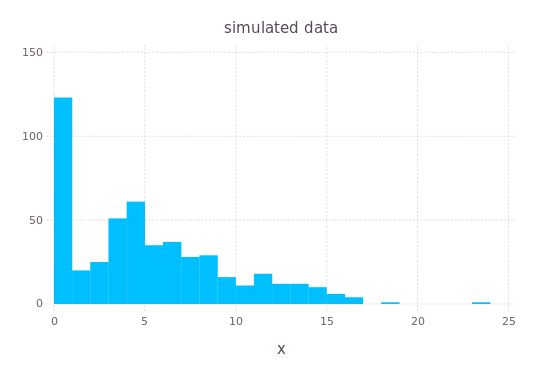

In [3]:
plot(x=y[1],Geom.histogram,Guide.title("simulated data"))

Next we run the sampler...

In [5]:
@time fit = topiclmm(y,pss,K,2000,4);

  3.821689 seconds (45.84 M allocations: 1.325 GB, 4.48% gc time)


We'll convert the infered component/topic weights to the relative probabilcomponent.

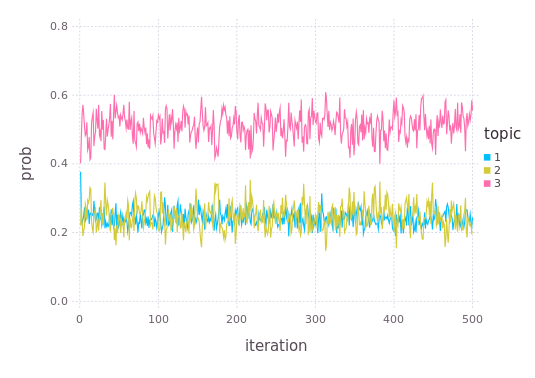

In [6]:
n = length(fit[:τ])
p = reshape(mapslices(softmax,fit[:η],1),(K,n));
pdat = DataFrame(prob = p[:],topic=repeat(map(string,1:K),outer=[n]),iteration=repeat(collect(1:n),inner=[K]));
plot(pdat,y="prob",x="iteration",color="topic",Geom.line)

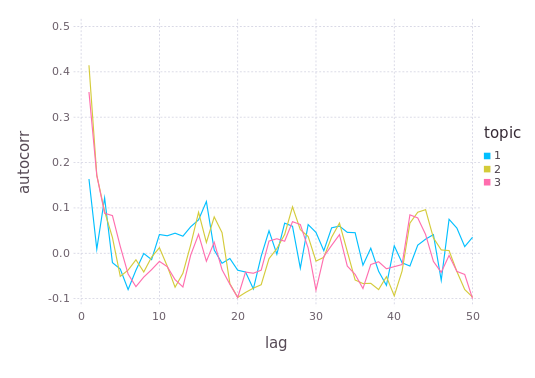

In [8]:
acor = mapslices(x -> autocor(x,1:50),p[:,div(n,10):n]',1)';
acdat = DataFrame(autocorr=acor[:],topic=repeat(map(string,1:K),outer=[50]),lag=repeat(collect(1:50),inner=[K]));
plot(acdat,y="autocorr",x="lag",color="topic",Geom.line)

Looks good.

We can also examine the inferred topic memberships for each datapoint. Below is a chart... image? whatever, where the y axis shows the different data points, x axis is sampler iteration number, and color indicates which component the data points are assigned to on each iteration.

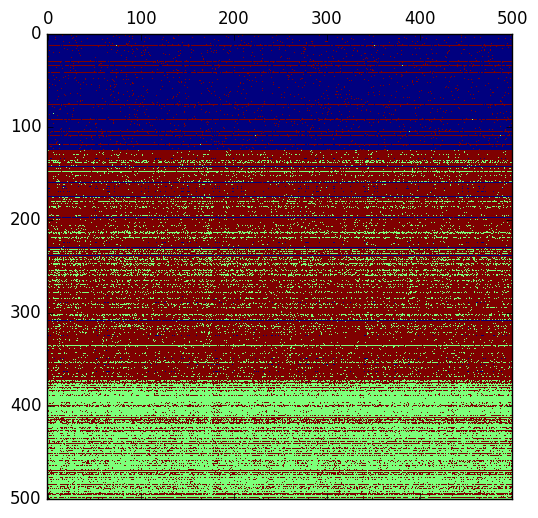

In [9]:
matshow(fit[:z][1]);

The model is correctly grouping most data points together. There are a few that the model gets wrong consistently, but that's to be expected, since there is overlap between the distributions.

Soooo... the code seems to be working. Yay! Next we'll do something more interesting and maybe even get back to dealing with real data for once.